In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import talib
import numpy as np
import yfinance as yf
from datetime import datetime, timedelta

In [3]:

def download_data(ticker, start_date, end_date):
    try:
        # Download data
        data = yf.download(ticker, start=start_date, end=end_date, interval='5m')
        return data
    except Exception as e:
        print("Error:", e)
        return None



def generate_features_labels(data):
    # Calculate EMA
    data['EMA_short'] = talib.EMA(data['Close'], timeperiod=short_period)
    data['EMA_long'] = talib.EMA(data['Close'], timeperiod=long_period)

    # Calculate MACD
    data['macd'], data['signal'], _ = talib.MACD(data['Close'])

    # Calculate RSI
    data['RSI'] = talib.RSI(data['Close'])

    # Calculate MFI
    data['MFI'] = talib.MFI(data['High'], data['Low'], data['Close'], data['Volume'])

    # Calculate SAR
    data['SAR'] = talib.SAR(data['High'], data['Low'])

    # Shift the indicators by one day to compare with the previous day's values
    for indicator in ['EMA_short', 'EMA_long', 'macd', 'signal', 'RSI', 'MFI', 'SAR']:
        data[indicator + '_prev'] = data[indicator].shift(1)
    data['close_prev'] = data['Close'].shift(1)

    # Generate signals
    buy_signals = (
        ((data['EMA_short'] >= data['EMA_long']) & (data['EMA_short_prev'] < data['EMA_long_prev'])) |
        ((data['macd'] >= data['signal']) & (data['macd_prev'] < data['signal_prev'])) |
        ((data['RSI'] <= 30) & (data['RSI_prev'] > 30)) |
        ((data['MFI'] <= 20) & (data['MFI_prev'] > 20)) |
        ((data['SAR'] <= data['Close']) & (data['SAR_prev'] > data['close_prev']))
    )

    sell_signals = (
        ((data['EMA_short'] <= data['EMA_long']) & (data['EMA_short_prev'] > data['EMA_long_prev'])) |
        ((data['macd'] <= data['signal']) & (data['macd_prev'] > data['signal_prev'])) |
        ((data['RSI'] >= 70) & (data['RSI_prev'] < 70)) |
        ((data['MFI'] >= 80) & (data['MFI_prev'] < 80)) |
        ((data['SAR'] >= data['Close']) & (data['SAR_prev'] < data['close_prev']))
    )

    data['signal'] = np.where(buy_signals, 1, np.where(sell_signals, -1, 0))
    
    # Drop NaN values
    data.dropna(inplace=True)
    
    # Features and labels
    X = data[['EMA_short', 'EMA_long', 'macd', 'signal', 'RSI', 'MFI', 'SAR']]
    y = data['signal']
    
    return X, y




In [4]:
ticker_symbol = "LT.NS"  # Example ticker symbol
start_date = "2024-05-06"  # Example start date
end_date = "2024-05-10"    # Example end date

data = download_data(ticker_symbol, start_date, end_date)
print(data)
type(data)

[*********************100%%**********************]  1 of 1 completed

                                  Open         High          Low        Close  \
Datetime                                                                        
2024-05-06 09:15:00+05:30  3507.600098  3510.850098  3488.000000  3491.100098   
2024-05-06 09:20:00+05:30  3489.300049  3492.550049  3483.699951  3487.000000   
2024-05-06 09:25:00+05:30  3489.949951  3492.000000  3486.050049  3491.000000   
2024-05-06 09:30:00+05:30  3491.500000  3492.000000  3488.649902  3490.000000   
2024-05-06 09:35:00+05:30  3489.899902  3489.949951  3473.500000  3475.000000   
...                                ...          ...          ...          ...   
2024-05-09 15:05:00+05:30  3272.149902  3276.850098  3270.500000  3274.600098   
2024-05-09 15:10:00+05:30  3274.250000  3275.899902  3270.800049  3272.500000   
2024-05-09 15:15:00+05:30  3272.250000  3276.600098  3270.000000  3275.949951   
2024-05-09 15:20:00+05:30  3276.000000  3280.000000  3275.000000  3278.949951   
2024-05-09 15:25:00+05:30  3

pandas.core.frame.DataFrame

In [5]:
data.reset_index(inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype                       
---  ------     --------------  -----                       
 0   Datetime   300 non-null    datetime64[ns, Asia/Kolkata]
 1   Open       300 non-null    float64                     
 2   High       300 non-null    float64                     
 3   Low        300 non-null    float64                     
 4   Close      300 non-null    float64                     
 5   Adj Close  300 non-null    float64                     
 6   Volume     300 non-null    int64                       
dtypes: datetime64[ns, Asia/Kolkata](1), float64(5), int64(1)
memory usage: 16.5 KB


In [6]:
short_period = 7
long_period = 15
X, y = generate_features_labels(data)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train Decision Tree Classifier
clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)

# Predictions
y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)
data['classified_signal'] = np.concatenate([y_pred_train, y_pred_test])



In [7]:
import plotly.graph_objects as go

# Specify the date you want to visualize
desired_date = '2024-05-06'  # Change this to the date you're interested in

# Filter data for the desired date
data_one_day = data[data['Datetime'].dt.date == pd.to_datetime(desired_date).date()]

# Plot candlestick chart for one day
fig = go.Figure(data=[go.Candlestick(x=data_one_day['Datetime'],
                open=data_one_day['Open'],
                high=data_one_day['High'],
                low=data_one_day['Low'],
                close=data_one_day['Close'])])


fig.show()



In [8]:
# Assuming 'data' is your DataFrame containing datetime, stock price, and classified signal columns

# Select columns containing datetime, stock price, and classified signal
selected_columns = ['Datetime', 'Close','signal']

# Create a new DataFrame with only the selected columns
final_data = data[selected_columns]

# Save the final data to a CSV file
final_data.to_csv('L&T_6_may_10may.csv', index=False)


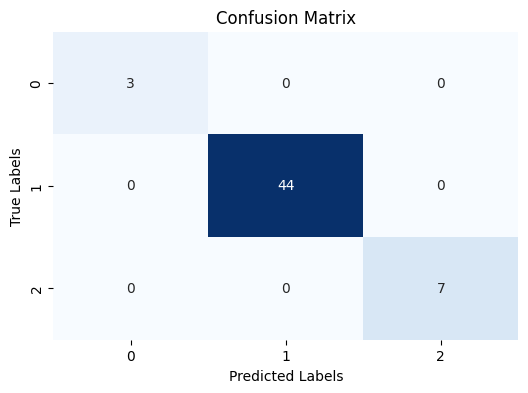

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming y_test and y_pred_test are already defined
# Example:
# y_test = [actual labels]
# y_pred_test = [predicted labels]

# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [13]:
from sklearn.metrics import confusion_matrix
import numpy as np
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 3  0  0]
 [ 0 44  0]
 [ 0  0  7]]
